# Нейронные сети
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][HW05] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

Для начала вам предстоит реализовать свой собственный backpropagation и протестировать его на реальных данных, а затем научиться обучать нейронные сети при помощи библиотеки `PyTorch` и использовать это умение для классификации классического набора данных CIFAR10.

In [1]:
from typing import List
import random

import numpy
from sklearn.datasets import make_blobs, make_moons

In [2]:
SEED=7
numpy.random.seed(SEED)
random.seed(SEED)

### Задание 1 (3 балла)
Нейронные сети состоят из слоев, поэтому для начала понадобится реализовать их. Пока нам понадобятся только три:

`Linear` - полносвязный слой, в котором `y = Wx + b`, где `y` - выход, `x` - вход, `W` - матрица весов, а `b` - смещение. 

`ReLU` - слой, соответствующий функции активации `y = max(0, x)`.

`Softmax` - слой, соответствующий функции активации [softmax](https://ru.wikipedia.org/wiki/Softmax)


#### Методы
`forward(X)` - возвращает предсказанные для `X`. `X` может быть как вектором, так и батчем

`backward(d)` - считает градиент при помощи обратного распространения ошибки. Возвращает новое значение `d`

`update(alpha)` - обновляет веса (если необходимо) с заданой скоростью обучения

In [3]:
class Module:
    """
    Абстрактный класс. Его менять не нужно.
    """

    _input = None
    def forward(self, *args):
        raise NotImplementedError()
    
    def backward(self, d):
        raise NotImplementedError()
        
    def update(self, alpha):
        pass

In [4]:
class Linear(Module):
    _grad_weights = None
    _grad_biases = None
    """
    Линейный полносвязный слой.
    """
    def __init__(self, in_features: int, out_features: int):
        """
        Parameters
        ----------
        in_features : int
            Размер входа.
        out_features : int 
            Размер выхода.
    
        Notes
        -----
        W и b инициализируются случайно.
        """
        self._weights = numpy.random.randn(in_features, out_features) * 0.01
        self._biases = numpy.zeros(out_features)
    
    def forward(self, x: numpy.ndarray) -> numpy.ndarray:
        """
        Возвращает y = Wx + b.

        Parameters
        ----------
        x : ndarray
            Входной вектор или батч.
            То есть, либо x вектор с in_features элементов,
            либо матрица размерности (batch_size, in_features).
    
        Return
        ------
        y : ndarray
            Выход после слоя.
            Либо вектор с out_features элементами,
            либо матрица размерности (batch_size, out_features)

        """
        self._input = x
        return x.dot(self._weights) + self._biases
    
    def backward(self, grad_output: numpy.ndarray) -> numpy.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        self._grad_weights = self._input.T.dot(grad_output)
        self._grad_biases = grad_output.sum(axis=0)

        return grad_output.dot(self._weights.T)
        
    def update(self, alpha: float):
        """
        Обновляет W и b с заданной скоростью обучения.

        Parameters
        ----------
        alpha : float
            Скорость обучения.
        """
        self._weights -= alpha * self._grad_weights
        self._biases -= alpha * self._grad_biases

In [5]:
class ReLU(Module):
    """
    Слой, соответствующий функции активации ReLU.
    """
    def __init__(self):
        pass
    
    def forward(self, x: numpy.ndarray) -> numpy.ndarray:
        """
        Возвращает y = max(0, x).

        Parameters
        ----------
        x : np.ndarray
            Входной вектор или батч.
    
        Return
        ------
        y : np.ndarray
            Выход после слоя (той же размерности, что и вход).

        """
        self._input = x
        return numpy.maximum(x, 0)
        
    def backward(self, d) -> numpy.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        relu_grad = self._input > 0
        return d * relu_grad
        
        
class SoftmaxCrossEntropy(Module):
    """
    Слой, соответствующий функции активации Softmax.
    """
    _true_labels = None

    def __init__(self):
        pass

    def forward(self, x: numpy.ndarray, true_labels: numpy.ndarray) -> numpy.ndarray:
        """
        Возвращает y = Softmax(x).

        Parameters
        ----------
        x : np.ndarray
            Входной вектор или батч.
    
        Return
        ------
        y : np.ndarray
            Выход после слоя (той же размерности, что и вход).

        """
        self._input = x
        self._true_labels = true_labels
        
        logits_for_answer = x[numpy.arange(x.shape[0]), self._true_labels]
        return -logits_for_answer + numpy.log(numpy.exp(x).sum(axis=-1))
        
    def backward(self, d) -> numpy.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        ones_for_answer = numpy.zeros_like(self._input)
        ones_for_answer[numpy.arange(self._input.shape[0]), self._true_labels] = 1

        exp = numpy.exp(self._input)
        softmax = exp / exp.sum(axis=-1, keepdims=True)
        return -ones_for_answer + softmax

### Задание 2 (2 балла)
Теперь сделаем саму нейронную сеть.

#### Методы
`fit(X, y)` - обучает нейронную сеть заданное число эпох. В каждой эпохе необходимо использовать [cross-entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) для обучения, а так же производить обновления не по одному элементу, а используя батчи.

`predict_proba(X)` - предсказывает вероятности классов для элементов `X`

#### Параметры конструктора
`modules` - список, состоящий из ранее реализованных модулей и описывающий слои нейронной сети. В конец необходимо добавить `Softmax`

`epochs` - количество эпох обучения

`alpha` - скорость обучения

In [6]:
class MLPClassifier:
    def __init__(self, modules: List[Module], epochs: int = 40, alpha: float = 0.01):
        """
        Parameters
        ----------
        modules : List[Module]
            Cписок, состоящий из ранее реализованных модулей и 
            описывающий слои нейронной сети. 
            В конец необходимо добавить Softmax.
        epochs : int
            Количество эпох обученияю
        alpha : float
            Cкорость обучения.
        """
        self._layers = modules
        self._n_epoch = epochs
        self._lr = alpha
            
    def fit(self, X: numpy.ndarray, y: numpy.ndarray, batch_size=32):
        """
        Обучает нейронную сеть заданное число эпох. 
        В каждой эпохе необходимо использовать cross-entropy loss для обучения, 
        а так же производить обновления не по одному элементу, а используя батчи.

        Parameters
        ----------
        X : np.ndarray
            Данные для обучения.
        y : np.ndarray
            Вектор меток классов для данных.
        batch_size : int
            Размер батча.
        """
        softmax_cross_entropy_loss = SoftmaxCrossEntropy()
        n_batches = X.shape[0] // batch_size + (0 if X.shape[0] % batch_size == 0 else 1)
        for epoch in range(self._n_epoch):
            for i in range(n_batches):
                cur_slice = slice(i * batch_size, min((i + 1) * batch_size, X.shape[0]))

                batch = X[cur_slice]
                for layer in self._layers:
                    batch = layer.forward(batch)

                loss = softmax_cross_entropy_loss.forward(batch, y[cur_slice])
#                 print(loss)

                upcomming_grad = softmax_cross_entropy_loss.backward(None)
                for layer in reversed(self._layers):
                    upcomming_grad = layer.backward(upcomming_grad)


                for layer in self._layers:
                    layer.update(self._lr)
        
    def predict_proba(self, X: numpy.ndarray) -> numpy.ndarray:
        """
        Предсказывает вероятности классов для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Данные для предсказания.
        
        Return
        ------
        np.ndarray
            Предсказанные вероятности классов для всех элементов X.
            Размерность (X.shape[0], n_classes)
        
        """
        for layer in self._layers:
            X = layer.forward(X)
        exp = numpy.exp(X)
        return exp / exp.sum(axis=-1, keepdims=True)
        
    def predict(self, X) -> numpy.ndarray:
        """
        Предсказывает метки классов для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Данные для предсказания.
        
        Return
        ------
        np.ndarray
            Вектор предсказанных классов
        
        """
        p = self.predict_proba(X)
        return numpy.argmax(p, axis=1)

In [7]:
p = MLPClassifier([
    Linear(4, 64),
    ReLU(),
    Linear(64, 64),
    ReLU(),
    Linear(64, 2)
])

X = numpy.random.randn(50, 4)
y = [(0 if x[0] > x[2]**2 or x[3]**3 > 0.5 else 1) for x in X]
p.fit(X, y)

### Задание 3 (2 балла)
Протестируем наше решение на синтетических данных. Необходимо подобрать гиперпараметры, при которых качество полученных классификаторов будет достаточным.

#### Оценка
Accuracy на первом датасете больше 0.85 - +1 балл

Accuracy на втором датасете больше 0.85 - +1 балл

In [8]:
X, y = make_moons(400, noise=0.075)
X_test, y_test = make_moons(400, noise=0.075)

best_acc = 0
for _ in range(25):
    p = MLPClassifier([Linear(2, 32), ReLU(), Linear(32, 2)], epochs=100)

    p.fit(X, y)
    best_acc = max(numpy.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

Accuracy 0.995


In [9]:
X, y = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
X_test, y_test = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
best_acc = 0
for _ in range(25):
    p = MLPClassifier([Linear(2, 32), ReLU(), Linear(32, 3)], epochs=100)

    p.fit(X, y)
    best_acc = max(numpy.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

Accuracy 0.9575


## PyTorch

Для выполнения следующего задания понадобится PyTorch. [Инструкция по установке](https://pytorch.org/get-started/locally/)

Если у вас нет GPU, то можно использовать [Google Colab](https://colab.research.google.com/)

In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = transforms.ToTensor()

cifar_train = datasets.CIFAR10("datasets/cifar10", download=True, train=True, transform=t)
train_loader = DataLoader(cifar_train, batch_size=1024, shuffle=True, pin_memory=torch.cuda.is_available())
cifar_test = datasets.CIFAR10("datasets/cifar10", download=True, train=False, transform=t)
test_loader = DataLoader(cifar_test, batch_size=1024, shuffle=False, pin_memory=torch.cuda.is_available())

Files already downloaded and verified
Files already downloaded and verified


### Задание 4 (3 балла)
А теперь поработам с настоящими нейронными сетями и настоящими данными. Необходимо реализовать сверточную нейронную сеть, которая будет классифицировать изображения из датасета CIFAR10. Имплементируйте класс `Model` и функцию `calculate_loss`. 

Обратите внимание, что `Model` должна считать в конце `softmax`, т.к. мы решаем задачу классификации. Соответствеено, функция `calculate_loss` считает cross-entropy.

Для успешного выполнения задания необходимо, чтобы `accuracy`, `mean precision` и `mean recall` были больше 0.5

__Можно пользоваться всем содержимым библиотеки PyTorch.__

In [12]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self._layers = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            
            nn.Conv2d(32, 32, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            
            nn.Flatten(),
            nn.Linear(4096, 256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._layers(x)
        
def calculate_loss(X: torch.Tensor, y: torch.Tensor, model: Model):
    """
    Cчитает cross-entropy.

    Parameters
    ----------
    X : torch.Tensor
        Данные для обучения.
    y : torch.Tensor
        Метки классов.
    model : Model
        Модель, которую будем обучать.

    """
    logits = model(X)
    return nn.functional.cross_entropy(logits, y)

Теперь обучим нашу модель. Для этого используем ранее созданные batch loader'ы.

In [13]:
def train(model, epochs=100):
    optimizer = torch.optim.Adam(model.parameters())
    train_losses = []
    test_losses = []
    for i in range(epochs):
        #Train
        loss_mean = 0
        elements = 0
        for X, y in iter(train_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * len(X)
            elements += len(X)
        train_losses.append(loss_mean / elements)
        #Test
        loss_mean = 0 
        elements = 0
        for X, y in iter(test_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            loss_mean += loss.item() * len(X)
            elements += len(X)
        test_losses.append(loss_mean / elements)
        print("Epoch", i, "| Train loss", train_losses[-1], "| Test loss", test_losses[-1])
    return train_losses, test_losses

In [14]:
model = Model().to(device)
train_l, test_l = train(model, epochs=25)

Epoch 0 | Train loss 2.0483265200805665 | Test loss 1.7990222259521484
Epoch 1 | Train loss 1.6562317849731445 | Test loss 1.5417714754104614
Epoch 2 | Train loss 1.4849501008987427 | Test loss 1.4420964521408082
Epoch 3 | Train loss 1.367998252067566 | Test loss 1.3303483995437622
Epoch 4 | Train loss 1.295308695640564 | Test loss 1.2761020544052124
Epoch 5 | Train loss 1.2149629946136475 | Test loss 1.2014528135299682
Epoch 6 | Train loss 1.1480359329986571 | Test loss 1.1554454216003418
Epoch 7 | Train loss 1.0990856608200072 | Test loss 1.1166933212280274
Epoch 8 | Train loss 1.0444721412467957 | Test loss 1.085098857498169
Epoch 9 | Train loss 1.0079493948745728 | Test loss 1.07614432888031
Epoch 10 | Train loss 0.9665773336219787 | Test loss 1.0361858976364136
Epoch 11 | Train loss 0.9320790217208862 | Test loss 1.0279901399612428
Epoch 12 | Train loss 0.9047576646614075 | Test loss 0.9954395523071289
Epoch 13 | Train loss 0.8813370776748657 | Test loss 0.9756577834129333
Epoch 1

Построим график функции потерь

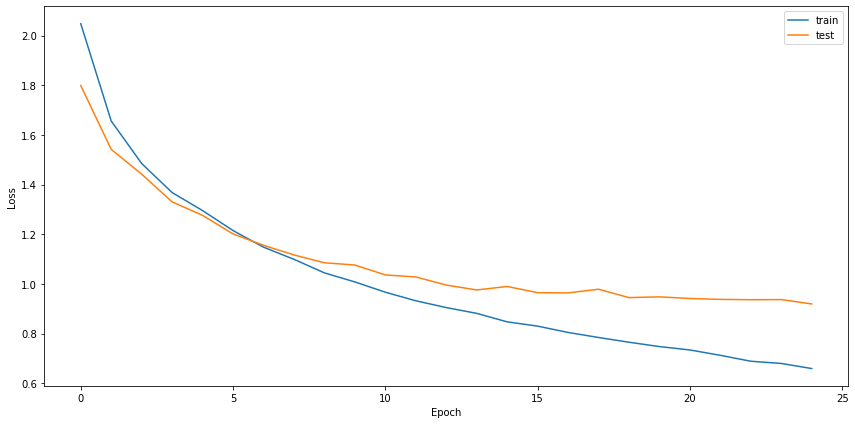

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_l)), train_l, label="train")
plt.plot(range(len(test_l)), test_l, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

И, наконец, посчитаем метрики

In [16]:
true_positive = numpy.zeros(10)
true_negative = numpy.zeros(10)
false_positive = numpy.zeros(10)
false_negative = numpy.zeros(10)
accuracy = 0
ctn = 0
for X, y in iter(test_loader):
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        y_pred = model(X).max(dim=1)[1]
    for i in range(10):
        for pred, real in zip(y_pred, y):
            if real == i:
                if pred == real:
                    true_positive[i] += 1
                else:
                    false_negative[i] += 1
            else:
                if pred == i:
                    false_positive[i] += 1
                else:
                    true_negative[i] += 1
            
    accuracy += torch.sum(y_pred == y).item()
    ctn += len(y)
print("Overall accuracy", accuracy / ctn)
print("Precision", true_positive / (true_positive + false_positive))
print("Recall", true_positive / (true_positive + false_negative))
print("Mean Precision", numpy.mean(true_positive / (true_positive + false_positive)))
print("Mean Recall", numpy.mean(true_positive / (true_positive + false_negative)))

Overall accuracy 0.6841
Precision [0.70392157 0.8006012  0.59278897 0.50484392 0.59051724 0.57560976
 0.77059437 0.75777063 0.77756654 0.77166157]
Recall [0.718 0.799 0.559 0.469 0.685 0.59  0.739 0.707 0.818 0.757]
Mean Precision 0.684587576932259
Mean Recall 0.6840999999999999
